In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy import signal, ndimage
import time

In [2]:
### Brute Force Implementation ###
class DisparityMap():
    def __init__(self, numDisparities, blockSize):
        self.numDisparities = numDisparities
        self.blockSize = blockSize
    
    def Hamming_distance(self, a, b):
        return sum(a[i]!=b[i] for i in range(len(a)))
        
    def CT(self, imgL, imgR):
        imgL = imgL.astype(np.float)
        imgR = imgR.astype(np.float)
        l, w = imgL.shape
        disparityMap = np.zeros((l, w))
        mid = int(self.blockSize/2)
        
        for i in range(mid, l-mid):
            for j in range(mid, w-mid):
                
                #Finding csl value for right block
                csr = ''
                for ii in range(i-mid, i+mid+1):
                    for jj in range(j-mid, j+mid+1):
                        if imgR[ii, jj]<imgR[i, j]:
                            csr += '0'
                        else:
                            csr += '1'
                
                #Comparing the csr_val with the left image and generating error
                errors = []
                for k in range(j, min(j+self.numDisparities, w-mid)):
                    #Finding csl value for right block
                    csl = ''
                    for ii in range(i-mid, i+mid+1):
                        for jj in range(k-mid, k+mid+1):
                            if imgL[ii, jj]<imgL[i, k]:
                                csl += '0'
                            else:
                                csl += '1'
                    errors.append(sum(csl[p]!=csr[p] for p in range(len(csl))))
                disparityMap[i, j] = np.argmin(errors)
        return disparityMap

In [12]:
imgL = cv2.imread('tsukuba_l.png', 0)
imgR = cv2.imread('tsukuba_r.png', 0)
disparity = DisparityMap(numDisparities=16, blockSize=11)

disparityMap1 = disparity.CT(imgL, imgR)
plt.imshow(disparityMap1, 'gray')
plt.show()

In [3]:
### Vecorized implementation using Numpy Library ###
class DisparityMap():
    def __init__(self, numDisparities, blockSize):
        self.numDisparities = numDisparities
        self.blockSize = blockSize
    
    def census_convolution(self, center, kernel_size=(5, 5)):
        row_padding, col_padding = kernel_size[0]//2, kernel_size[1]//2
        image = cv2.copyMakeBorder(center, top=row_padding, left=col_padding, right=col_padding, bottom=row_padding, borderType=cv2.BORDER_CONSTANT, value=0)
        output = np.zeros(center.shape, dtype=np.uint8)
        r, c = center.shape
        
        bits = 0
        outputs = []
        for row in range(kernel_size[0]):
            for col in range(kernel_size[1]):                  
                output = (output << 1) | (image[row:row+r, col:col+c] >= center)
                bits += 1
                if bits%8==0 and bits!=0:
                    outputs.append(output.copy())
                    output = np.zeros(center.shape, dtype=np.uint8)
                    
        if (kernel_size[0]*kernel_size[1])%8!=0:
            outputs.append(output.copy())
        outputs = np.array(outputs)
        return outputs

    def find_difference(self, left, right, shift_val):
        left_t = left.copy()
        right_t = right.copy()
        if len(left.shape)==2:
            r, c = left.shape
            left_t[:, :c-shift_val] = left_t[:, shift_val:]
            output = np.sum(np.unpackbits(np.bitwise_xor(left_t.reshape(r*c,1), right_t.reshape(r*c,1)), axis = 1), axis=1).reshape(r, c)
        else:
            n, r, c = left_t.shape
            left_t[:, :, :c-shift_val] = left_t[:, :, shift_val:]
            output = np.sum(np.sum(np.unpackbits(np.bitwise_xor(left_t.reshape(n*r*c,1), right_t.reshape(n*r*c,1)), axis = 1), axis=1).reshape(n, r, c), axis=0)
            
        return output
        
    def CT(self, imgL, imgR, window_size):
        imgL = imgL.astype(np.float)
        imgR = imgR.astype(np.float)
        l, w = imgL.shape
        
        #find census for left and right image
        left = self.census_convolution(imgL, window_size)
        right = self.census_convolution(imgR, window_size)
        
        #Finding error for all the numDisparities
        errors = []
        for i in range(self.numDisparities):
            errors.append(self.find_difference(left, right, i))
        
        errors = np.array(errors)
        
        disparityMap = np.zeros((l, w), dtype=np.uint8)
        mid = int(self.blockSize/2)
        for i in range(mid, l-mid):
            for j in range(mid, min(w-self.numDisparities, w-mid)):
                disparityMap[i, j] = np.argmin(errors[:,i,j])
        #disparityMap = disparityMap/self.numDisparities
        return disparityMap
    
    def CT_with_MBM(self, imgL, imgR):
        imgL = imgL.astype(np.float)
        imgR = imgR.astype(np.float)
        l, w = imgL.shape
        
        kernels = [(1, 61), (61, 1), (11, 11), (3, 3)]
        census_convs = []
        for kernel_size in kernels:
            #find census for left and right image
            left = self.census_convolution(imgL, kernel_size)
            right = self.census_convolution(imgR, kernel_size)
        
            #Finding error for all the numDisparities
            errors = []
            for i in range(self.numDisparities):
                errors.append(self.find_difference(left, right, i)/(kernel_size[0]*kernel_size[1]))
            errors = np.array(errors)
            
            census_convs.append(errors)
        
        out = np.minimum(census_convs[0], census_convs[1]) 
        out = np.multiply(out, census_convs[2])
        out = np.multiply(out, census_convs[3])
        
        disparityMap = np.zeros((l, w), dtype=np.uint8)
        mid = int(self.blockSize/2)
        for i in range(mid, l-mid):
            for j in range(mid, min(w-self.numDisparities, w-mid)):
                disparityMap[i, j] = np.argmin(out[:,i,j])
        #disparityMap = disparityMap/self.numDisparities
        return disparityMap
    
    def CT_with_input_kernels(self, imgL, imgR, kernels):
        imgL = imgL.astype(np.float)
        imgR = imgR.astype(np.float)
        l, w = imgL.shape
        
        census_convs = []
        for kernel_size in kernels:
            #find census for left and right image
            left = self.census_convolution(imgL, kernel_size)
            right = self.census_convolution(imgR, kernel_size)
        
            #Finding error for all the numDisparities
            errors = []
            for i in range(self.numDisparities):
                errors.append(self.find_difference(left, right, i)/(kernel_size[0]*kernel_size[1]))
            errors = np.array(errors)
            
            census_convs.append(errors)
        
        out = census_convs[0]
        for i in range(1, len(kernels)):
            out = np.multiply(out, census_convs[i])

        disparityMap = np.zeros((l, w), dtype=np.uint8)
        mid = int(self.blockSize/2)
        for i in range(mid, l-mid):
            for j in range(mid, min(w-self.numDisparities, w-mid)):
                disparityMap[i, j] = np.argmin(out[:,i,j])
        #disparityMap = disparityMap/self.numDisparities
        return disparityMap
    
    #Generating Locally Consistent Disparity Map
    def LCDM(self, disparityMap, kernel):
        disparityMap = disparityMap.astype(np.int64)
        output = disparityMap.copy()
        r, c = imgL.shape
        row_mid, col_mid = kernel[0]//2, kernel[1]//2
        
        for i in range(2*row_mid, r-2*row_mid):
            for j in range(2*col_mid, min(c-numdisparities-col_mid, c-2*col_mid)):
                temp = disparityMap[i-row_mid:i+row_mid+1, j-col_mid:j+col_mid+1]
                val = np.bincount(temp.reshape(1, kernel[0]*kernel[1])[0]).argmax()
                output[i, j] = val
        
        return output

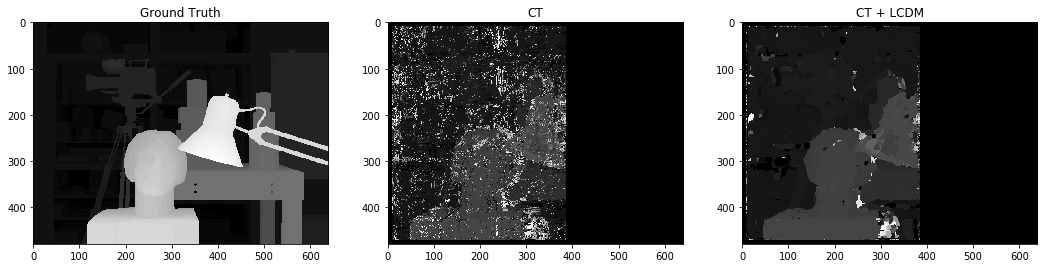

"\nplt.figure(figsize=(18, 54))\nplt.subplot(131)\nplt.imshow(imgR, 'gray')\nplt.title('Right Image')\n\nplt.subplot(132)\nplt.imshow(error1, 'gray')\nplt.title('Bad Error 1.0= '+str(error_per1)+'%')\n\nplt.subplot(133)\nplt.imshow(error2, 'gray')\nplt.title('LCDM. Bad Error 1.0= '+str(error_per2)+'%')\nplt.show()\n"

In [6]:
# imgL = cv2.imread('tsukuba_l.png', 0)
# imgR = cv2.imread('tsukuba_r.png', 0)

imgL = cv2.imread('2001/tsukuba/imgL.png', 0)
imgR = cv2.imread('2001/tsukuba/imgR.png', 0)
ground_truth = cv2.imread('2001/tsukuba/ground_truth.png', 0)

# imgL = cv2.imread('2001/cones/im2.png', 0)
# imgR = cv2.imread('2001/cones/im6.png', 0)
# ground_truth = cv2.imread('2001/cones/disp6.png', 0)/4

# imgL = cv2.imread('2001/teddy/im2.png', 0)
# imgR = cv2.imread('2001/teddy/im6.png', 0)
# ground_truth = cv2.imread('2001/teddy/disp6.png', 0)/4

# imgL = cv2.imread('2001/sawtooth/im2.ppm', 0)
# imgR = cv2.imread('2001/sawtooth/im6.ppm', 0)
# ground_truth = cv2.imread('2001/sawtooth/disp6.pgm', 0)/8

# imgL = cv2.imread('2001/venus/im2.ppm', 0)
# imgR = cv2.imread('2001/venus/im6.ppm', 0)
# ground_truth = cv2.imread('2001/venus/disp6.pgm', 0)/8

# imgL = cv2.imread('2001/barn1/im2.ppm', 0)
# imgR = cv2.imread('2001/barn1/im6.ppm', 0)
# ground_truth = cv2.imread('2001/barn1/disp6.pgm', 0)/8

# imgL = cv2.imread('2001/bull/im2.ppm', 0)
# imgR = cv2.imread('2001/bull/im6.ppm', 0)
# ground_truth = cv2.imread('2001/bull/disp6.pgm', 0)/8

blocksize = 16
numdisparities = 256
disparity = DisparityMap(numDisparities=numdisparities, blockSize=blocksize)

disparityMap1 = disparity.CT(imgL, imgR, (11, 11))
#disparityMap1 = disparity.CT_with_MBM(imgL, imgR)

#disparityMap1 = disparity.CT_with_input_kernels(imgL, imgR, [(3, 17), (11, 11)])

disparityMap2 = disparity.LCDM(disparityMap1, (11, 11))

#cv2.imwrite('CT_GT.png', disparityMap2)
# disparityMap2 = disparityMap2.astype(np.uint8)
# disparityMap2 = cv2.bilateralFilter(disparityMap2, 50, 10, 1)

'''
###############################################################
##Cropping the ground truth
r, c = ground_truth.shape
ground_truth[:int(blocksize/2), :] = 0
ground_truth[:, :int(blocksize/2)] = 0
ground_truth[r-int(blocksize/2):, :] = 0
ground_truth[:, c-numdisparities:] = 0

##Calculating error
error1 = abs(ground_truth-disparityMap1)>1
error_per1 = np.round(100*sum(error1.reshape(r*c, 1))[0]/(r*c), 2)

error2 = abs(ground_truth-disparityMap2)>1
error_per2 = np.round(100*sum(error2.reshape(r*c, 1))[0]/(r*c), 2)
'''
##################################################################

plt.figure(figsize=(18, 54))
plt.subplot(131)
plt.imshow(ground_truth, 'gray')
plt.title('Ground Truth')

plt.subplot(132)
plt.imshow(disparityMap1, 'gray')
plt.title('CT')

plt.subplot(133)
plt.imshow(disparityMap2, 'gray')
plt.title('CT + LCDM')
plt.show()

###################################################################
'''
plt.figure(figsize=(18, 54))
plt.subplot(131)
plt.imshow(imgR, 'gray')
plt.title('Right Image')

plt.subplot(132)
plt.imshow(error1, 'gray')
plt.title('Bad Error 1.0= '+str(error_per1)+'%')

plt.subplot(133)
plt.imshow(error2, 'gray')
plt.title('LCDM. Bad Error 1.0= '+str(error_per2)+'%')
plt.show()
'''

### Plotting Processing time taken by all methods

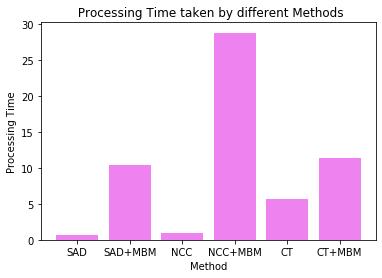

In [9]:
# SAD: 0.6502611637115479
# MBM+SAD: 10.419725894927979
    
# NCC: 0.9863951206207275
# NCC+MBM: 28.800822257995605
    
# CT:  5.6510467529296875
# CT+MBM:  11.373523235321045

t1 = 0.6502611637115479
t2 = 10.419725894927979
    
t3 = 0.9863951206207275
t4 = 28.800822257995605
    
t5 = 5.6510467529296875
t6 = 11.373523235321045
    
Processing_Times = [t1, t2, t3, t4, t5, t6]
x = ['SAD', 'SAD+MBM', 'NCC', 'NCC+MBM', 'CT', 'CT+MBM']
x_position = [i for i in range(len(x))]
plt.bar(x_position, Processing_Times, color='violet')
plt.xlabel("Method")
plt.ylabel("Processing Time")
plt.title(" Processing Time taken by different Methods")
plt.xticks(x_position, x)
plt.show()

In [ ]:
# imgL = cv2.imread('tsukuba_l.png', 0)
# imgR = cv2.imread('tsukuba_r.png', 0)
# imgL = cv2.imread('2001/cones/im2.png', 0)
# imgR = cv2.imread('2001/cones/im6.png', 0)
# blocksize = 11
# numdisparities = 64
# disparity = DisparityMap(numDisparities=numdisparities, blockSize=blocksize)

# disparityMap1 = disparity.CT(imgL, imgR, (9, 9))
# plt.imshow(disparityMap, 'gray')
# plt.show()
# # disparityMap2 = disparity.CT_with_MBM(imgL, imgR)
# # plt.imshow(disparityMap, 'gray')
# # plt.show()
# disparityMap3 = disparity.CT_with_input_kernels(imgL, imgR, [(3, 17), (11, 11)])
# plt.imshow(disparityMap, 'gray')
# plt.show()

# disparityMap4 = cv2.bilateralFilter(disparityMap3, 60, 23, 10)
# plt.imshow(disparityMap4, 'gray')
# plt.show()

################################################################
ground_truth = cv2.imread('2001/cones/disp6.png', 0)/4
r, c = ground_truth.shape
ground_truth[:int(blocksize/2), :] = 0
ground_truth[:, :int(blocksize/2)] = 0
ground_truth[r-int(blocksize/2):, :] = 0
ground_truth[:, c-numdisparities:] = 0
plt.imshow(ground_truth, 'gray')
plt.show()

################################################################
##Calculating error
error1 = abs(ground_truth-disparityMap1)>1
error_cnt1 = sum([sum(error1[i][:]) for i in range(r)])
plt.imshow(error1, 'gray')
plt.show()

error2 = abs(ground_truth-disparityMap2)>1
error_cnt2 = sum([sum(error2[i][:]) for i in range(r)])
plt.imshow(error2, 'gray')
plt.show()

# error3 = abs(ground_truth-disparityMap3)>1
# error_cnt3 = sum([sum(error3[i][:]) for i in range(r)])
# plt.imshow(error3, 'gray')
# plt.show()

# error4 = abs(ground_truth-disparityMap4)>1
# error_cnt4 = sum([sum(error4[i][:]) for i in range(r)])
# plt.imshow(error4, 'gray')
# plt.show()

#Printing errors
print("Bad Pixels Error in percentage: ", 100*error_cnt1/(r*c))
print("Bad Pixels Error in percentage: ", 100*error_cnt2/(r*c))
# print("Bad Pixels Error in percentage: ", 100*error_cnt3/(r*c))
# print("Bad Pixels Error in percentage: ", 100*error_cnt4/(r*c))

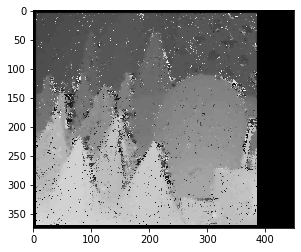

In [229]:
bilateral = cv2.bilateralFilter(disparityMap3, 7, 13, 10)
plt.imshow(bilateral, 'gray')
plt.show()